# KNN Baseline Model



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', '{:.4f}'.format)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Preparation

In [2]:
# Load the feature engineered training data
print("Loading feature engineered training data...")
try:
    df_train = pd.read_csv("../data/training_set_VU_DM_feature_engin.csv")
    print(f"Loaded training dataset with shape: {df_train.shape}")
except FileNotFoundError:
    print("Feature engineered training file not found. Loading original and applying basic feature engineering...")
    df_train = pd.read_csv("../data/training_set_VU_DM.csv")
    print(f"Loaded original training dataset with shape: {df_train.shape}")
    

    for col in df_train.select_dtypes(include=[np.number]).columns:
        if df_train[col].isnull().any():
            df_train[col] = df_train[col].fillna(df_train[col].median())

    df_train['price_per_night'] = df_train['price_usd'] / df_train['srch_length_of_stay']
    df_train.loc[df_train['srch_length_of_stay'] == 0, 'price_per_night'] = df_train['price_usd']
    
    df_train['value_for_money_normalized'] = df_train['prop_starrating'] / df_train['price_per_night']
    df_train['value_for_money_normalized'] = df_train['value_for_money_normalized'] / df_train['value_for_money_normalized'].max()
    
    df_train['price_normalized'] = df_train.groupby('srch_id')['price_usd'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-10))
    
    df_train['price_rank_pct'] = df_train.groupby('srch_id')['price_usd'].rank(pct=True)
    
    df_train['prop_country_rank_pct'] = df_train.groupby('prop_country_id')['prop_starrating'].rank(pct=True)
    
    df_train['star_rating_for_price'] = df_train['prop_starrating'] / np.log1p(df_train['price_per_night'])
    
    df_train['quality_price_ratio'] = (0.5 * (df_train['prop_starrating'] / 5) + 
                                       0.5 * (df_train['prop_review_score'] / 5)) / df_train['price_normalized']
    df_train['quality_price_ratio'] = df_train['quality_price_ratio'].fillna(df_train['quality_price_ratio'].median())
    df_train['quality_price_ratio'] = df_train['quality_price_ratio'].replace([np.inf, -np.inf], 
                                                                               df_train['quality_price_ratio'].median())
    

    df_train['price_discount'] = 1 - (df_train['price_usd'] / np.exp(df_train['prop_log_historical_price']))

# Display basic info
print(f"\nDataset shape: {df_train.shape}")
print(f"Number of unique searches: {df_train['srch_id'].nunique():,}")
print(f"Number of unique hotels: {df_train['prop_id'].nunique():,}")

Loading feature engineered training data...
Loaded training dataset with shape: (4958347, 150)

Dataset shape: (4958347, 150)
Number of unique searches: 199,795
Number of unique hotels: 129,113



Relevance score distribution:
relevance
0    4736468
1      83489
2     138390
Name: count, dtype: int64


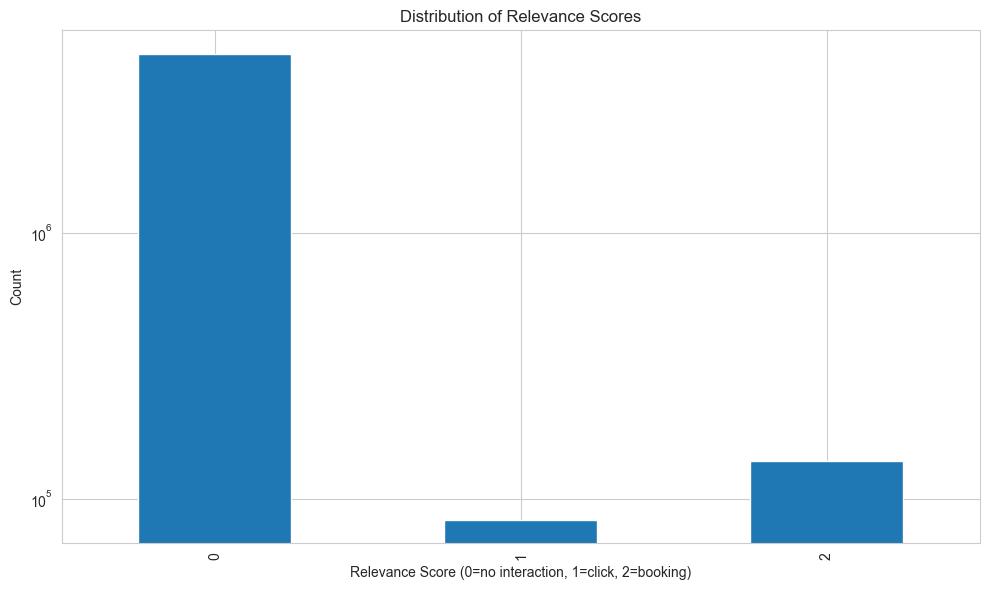

In [3]:
# Create relevance score based on clicks and bookings
if 'click_bool' in df_train.columns and 'booking_bool' in df_train.columns:
    df_train['relevance'] = 0
    df_train.loc[df_train['click_bool'] == 1, 'relevance'] = 1
    df_train.loc[df_train['booking_bool'] == 1, 'relevance'] = 2
    
    print("\nRelevance score distribution:")
    print(df_train['relevance'].value_counts().sort_index())
    
    # Visualize relevance distribution
    plt.figure(figsize=(10, 6))
    df_train['relevance'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Relevance Scores')
    plt.xlabel('Relevance Score (0=no interaction, 1=click, 2=booking)')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: click_bool or booking_bool columns not found. Creating dummy relevance scores.")
    df_train['relevance'] = 0

## 2. Feature Selection - Top 10 Features

Based on the feature importance analysis from the main experiment notebook, we select the top 10 most important features for our KNN model.

In [4]:
# Define top 10 features based on importance analysis from main experiment
# These are the features that showed highest importance in the LightGBM model
top_10_features = [
    'prop_location_score2',      # Most important feature
    'price_discount',            # Price-related feature
    'price_rank_pct',           # Ranking within search
    'prop_location_score1',     # Location quality
    'prop_country_rank_pct',    # Hotel ranking within country
    'star_rating_for_price',    # Value metric
    'quality_price_ratio',      # Quality vs price
    'promotion_flag',           # Promotion indicator
    'prop_review_score',        # Review quality
    'price_usd'                 # Base price
]


available_features = [f for f in top_10_features if f in df_train.columns]
missing_features = [f for f in top_10_features if f not in df_train.columns]

print(f"Available features ({len(available_features)}/10): {available_features}")
if missing_features:
    print(f"Missing features: {missing_features}")
    

    for feature in missing_features:
        if feature == 'price_discount' and 'price_discount' not in df_train.columns:
            df_train['price_discount'] = 1 - (df_train['price_usd'] / 
                                             np.exp(df_train['prop_log_historical_price']))
            available_features.append('price_discount')
        elif feature == 'price_rank_pct' and 'price_rank_pct' not in df_train.columns:
            df_train['price_rank_pct'] = df_train.groupby('srch_id')['price_usd'].rank(pct=True)
            available_features.append('price_rank_pct')
        elif feature == 'prop_country_rank_pct' and 'prop_country_rank_pct' not in df_train.columns:
            df_train['prop_country_rank_pct'] = df_train.groupby('prop_country_id')['prop_starrating'].rank(pct=True)
            available_features.append('prop_country_rank_pct')
        elif feature == 'star_rating_for_price' and 'star_rating_for_price' not in df_train.columns:
            df_train['price_per_night'] = df_train['price_usd'] / df_train['srch_length_of_stay']
            df_train.loc[df_train['srch_length_of_stay'] == 0, 'price_per_night'] = df_train['price_usd']
            df_train['star_rating_for_price'] = df_train['prop_starrating'] / np.log1p(df_train['price_per_night'])
            available_features.append('star_rating_for_price')
        elif feature == 'quality_price_ratio' and 'quality_price_ratio' not in df_train.columns:
            df_train['price_normalized'] = df_train.groupby('srch_id')['price_usd'].transform(
                lambda x: (x - x.min()) / (x.max() - x.min() + 1e-10))
            df_train['quality_price_ratio'] = (0.5 * (df_train['prop_starrating'] / 5) + 
                                               0.5 * (df_train['prop_review_score'] / 5)) / (df_train['price_normalized'] + 1e-10)
            df_train['quality_price_ratio'] = df_train['quality_price_ratio'].replace([np.inf, -np.inf], 
                                                                                       df_train['quality_price_ratio'].median())
            available_features.append('quality_price_ratio')
    

    missing_features = [f for f in top_10_features if f not in df_train.columns]
    
# Use available features for modeling
model_features = [f for f in available_features if f in df_train.columns]
print(f"\nFinal features for modeling ({len(model_features)}): {model_features}")

Available features (10/10): ['prop_location_score2', 'price_discount', 'price_rank_pct', 'prop_location_score1', 'prop_country_rank_pct', 'star_rating_for_price', 'quality_price_ratio', 'promotion_flag', 'prop_review_score', 'price_usd']

Final features for modeling (10): ['prop_location_score2', 'price_discount', 'price_rank_pct', 'prop_location_score1', 'prop_country_rank_pct', 'star_rating_for_price', 'quality_price_ratio', 'promotion_flag', 'prop_review_score', 'price_usd']


In [5]:
# Analyze the selected features
print("Feature statistics:")
feature_stats = df_train[model_features].describe().T
print(feature_stats)

# Check for missing values in selected features
missing_in_features = df_train[model_features].isnull().sum()
if missing_in_features.sum() > 0:
    print("\nMissing values in selected features:")
    print(missing_in_features[missing_in_features > 0])
    

    for col in model_features:
        if df_train[col].isnull().any():
            median_val = df_train[col].median()
            df_train[col] = df_train[col].fillna(median_val)
            print(f"Filled {col} missing values with median: {median_val}")
else:
    print("\nNo missing values in selected features.")

Feature statistics:
                             count     mean        std            min     25%      50%      75%           max
prop_location_score2  4958347.0000   0.1267     0.1472         0.0000  0.0223   0.0855   0.1549        1.0000
price_discount        4958347.0000 -50.3981 12407.8512 -19726327.0000 -0.1741   0.1415   0.3131        1.0000
price_rank_pct        4958347.0000   0.5201     0.2882         0.0263  0.2727   0.5172   0.7727        1.0000
prop_location_score1  4958347.0000   2.8726     1.5310         0.0000  1.7900   2.7700   4.0400        6.9800
prop_country_rank_pct 4958347.0000   0.5000     0.2707         0.0002  0.2619   0.4973   0.7836        1.0000
star_rating_for_price 4958347.0000   0.8150    11.7311         0.0000  0.6164   0.7574   0.9194     6801.9998
quality_price_ratio   4958347.0000   5.3298    70.4113         0.0000  1.3993   2.4391   4.2350    63397.5000
promotion_flag        4958347.0000   0.2156     0.4113         0.0000  0.0000   0.0000   0.0000     

## 3. Data Sampling for Efficient Training

Since KNN can be computationally expensive on large datasets, we'll use a sample of the data for training while ensuring we maintain the search group structure.

In [6]:

SAMPLE_FRACTION = 0.1  # Use 10% of searches

print(f"Sampling {SAMPLE_FRACTION*100}% of the data for training...")

# Sample search IDs to maintain group structure
unique_searches = df_train['srch_id'].unique()
n_sample_searches = int(len(unique_searches) * SAMPLE_FRACTION)
sampled_searches = np.random.choice(unique_searches, size=n_sample_searches, replace=False)

# Filter data to sampled searches
df_sample = df_train[df_train['srch_id'].isin(sampled_searches)].copy()

print(f"Original data: {len(df_train):,} rows, {df_train['srch_id'].nunique():,} searches")
print(f"Sampled data: {len(df_sample):,} rows, {df_sample['srch_id'].nunique():,} searches")

# Prepare features and target
X = df_sample[model_features].copy()
y = df_sample['relevance'].copy()
groups = df_sample['srch_id'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution in sample:")
print(y.value_counts().sort_index())

Sampling 10.0% of the data for training...
Original data: 4,958,347 rows, 199,795 searches
Sampled data: 495,448 rows, 19,979 searches

Feature matrix shape: (495448, 10)
Target distribution in sample:
relevance
0    473272
1      8373
2     13803
Name: count, dtype: int64


## 4. Feature Scaling and Preprocessing

In [7]:
# Feature scaling - important for KNN
print("Scaling features...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=model_features, index=X.index)

print("Feature scaling completed.")
print("\nScaled feature statistics:")
print(X_scaled.describe().T)

Scaling features...
Feature scaling completed.

Scaled feature statistics:
                            count    mean    std       min     25%     50%     75%      max
prop_location_score2  495448.0000  0.0000 1.0000   -0.8575 -0.7065 -0.2821  0.1850   5.9116
price_discount        495448.0000  0.0000 1.0000 -680.1749  0.0038  0.0038  0.0038   0.0039
price_rank_pct        495448.0000  0.0000 1.0000   -1.7109 -0.8585 -0.0101  0.8763   1.6648
prop_location_score1  495448.0000 -0.0000 1.0000   -1.8704 -0.7104 -0.0754  0.7606   2.6528
prop_country_rank_pct 495448.0000 -0.0000 1.0000   -1.8396 -0.8787 -0.0096  1.0444   1.8089
star_rating_for_price 495448.0000 -0.0000 1.0000   -1.7304 -0.3545 -0.0396  0.3211 121.7412
quality_price_ratio   495448.0000  0.0000 1.0000   -0.0833 -0.0613 -0.0449 -0.0166 501.3154
promotion_flag        495448.0000  0.0000 1.0000   -0.5264 -0.5264 -0.5264 -0.5264   1.8998
prop_review_score     495448.0000 -0.0000 1.0000   -3.5761 -0.2618  0.2117  0.6852   1.1587
price

## 5. KNN-Based Ranking Model Implementation



In [8]:
class KNNRankingModel:

    
    def __init__(self, n_neighbors=5, metric='euclidean', weights='distance'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weights = weights
        self.knn_model = None
        self.feature_names = None
        
    def fit(self, X, y):

        self.feature_names = X.columns.tolist() if hasattr(X, 'columns') else None
        
        # Initialize KNN model
        self.knn_model = NearestNeighbors(
            n_neighbors=self.n_neighbors,
            metric=self.metric,
            algorithm='auto'
        )
        
        # Fit the model
        self.knn_model.fit(X)
        
        # Store training targets for prediction
        self.y_train = y.values if hasattr(y, 'values') else y
        
        return self
    
    def predict(self, X):

        if self.knn_model is None:
            raise ValueError("Model must be fitted before prediction")
        
        # Find neighbors
        distances, indices = self.knn_model.kneighbors(X)
        
        # Predict based on neighbors
        predictions = []
        
        for i in range(len(X)):
            neighbor_distances = distances[i]
            neighbor_indices = indices[i]
            neighbor_targets = self.y_train[neighbor_indices]
            
            if self.weights == 'uniform':
                # Simple average
                pred = np.mean(neighbor_targets)
            elif self.weights == 'distance':
                # Distance-weighted average
                if np.sum(neighbor_distances) == 0:
                    # If all distances are 0, use uniform weights
                    pred = np.mean(neighbor_targets)
                else:
                    # Use inverse distance as weights
                    weights = 1.0 / (neighbor_distances + 1e-8)
                    pred = np.average(neighbor_targets, weights=weights)
            else:
                pred = np.mean(neighbor_targets)
            
            predictions.append(pred)
        
        return np.array(predictions)
    
    def rank_within_searches(self, X, search_ids):

        predictions = self.predict(X)
        
        # Create results dataframe
        results = pd.DataFrame({
            'search_id': search_ids,
            'predicted_relevance': predictions
        })
        
        # Rank within each search (higher relevance = better rank)
        results['rank'] = results.groupby('search_id')['predicted_relevance'].rank(
            method='dense', ascending=False)
        
        return results

print("KNN Ranking Model class defined.")

KNN Ranking Model class defined.


## 6. Cross-Validation and Model Evaluation

In [9]:
def calculate_ndcg_at_k(y_true, y_pred, k=5):
    """
    Calculate NDCG@K for ranking evaluation.
    """
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Handle case where we have fewer than k items
    if len(y_true) < k:
        k = len(y_true)
    
    if k == 0:
        return 0.0
    
    # Use sklearn's ndcg_score with appropriate label gains
    # Reshape for sklearn (expects 2D arrays)
    y_true_2d = y_true.reshape(1, -1)
    y_pred_2d = y_pred.reshape(1, -1)
    
    return ndcg_score(y_true_2d, y_pred_2d, k=k)


def evaluate_ranking_model(model, X, y, search_ids, k=5):
    """
    Evaluate ranking model using NDCG@K.
    """
    # Get predictions and rankings
    results = model.rank_within_searches(X, search_ids)
    
    # Calculate NDCG@K for each search
    ndcg_scores = []
    
    for search_id in search_ids.unique():
        # Get data for this search
        search_mask = search_ids == search_id
        search_y_true = y[search_mask].values
        search_predictions = results[results['search_id'] == search_id]['predicted_relevance'].values
        
        # Calculate NDCG@K for this search
        ndcg = calculate_ndcg_at_k(search_y_true, search_predictions, k=k)
        ndcg_scores.append(ndcg)
    
    return np.mean(ndcg_scores), np.std(ndcg_scores), ndcg_scores

print("Evaluation functions defined.")

Evaluation functions defined.


In [10]:
# Perform cross-validation using GroupKFold
print("Performing cross-validation...")

N_FOLDS = 3  # Use fewer folds due to computational cost of KNN
K_VALUES = [3, 5, 7, 10]  # Different values of K to test

# Initialize results storage
cv_results = {}

# Group K-Fold cross-validation (groups by search_id)
gkf = GroupKFold(n_splits=N_FOLDS)

for k_neighbors in K_VALUES:
    print(f"\n--- Testing K={k_neighbors} ---")
    
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X_scaled, y, groups=groups)):
        print(f"Fold {fold + 1}/{N_FOLDS}")
        
        # Split data
        X_train_fold = X_scaled.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X_scaled.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]
        groups_val_fold = groups.iloc[val_idx]
        
        # Train model
        model = KNNRankingModel(n_neighbors=k_neighbors, weights='distance')
        model.fit(X_train_fold, y_train_fold)
        
        # Evaluate
        mean_ndcg, std_ndcg, _ = evaluate_ranking_model(
            model, X_val_fold, y_val_fold, groups_val_fold, k=5)
        
        fold_scores.append(mean_ndcg)
        print(f"  NDCG@5: {mean_ndcg:.4f}")
    
    # Store results
    cv_results[k_neighbors] = {
        'mean_ndcg': np.mean(fold_scores),
        'std_ndcg': np.std(fold_scores),
        'fold_scores': fold_scores
    }
    
    print(f"  Average NDCG@5: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)

for k_neighbors, results in cv_results.items():
    print(f"K={k_neighbors}: NDCG@5 = {results['mean_ndcg']:.4f} ± {results['std_ndcg']:.4f}")

# Find best K
best_k = max(cv_results.keys(), key=lambda k: cv_results[k]['mean_ndcg'])
print(f"\nBest K: {best_k} (NDCG@5: {cv_results[best_k]['mean_ndcg']:.4f})")

Performing cross-validation...

--- Testing K=3 ---
Fold 1/3
  NDCG@5: 0.2058
Fold 2/3
  NDCG@5: 0.2041
Fold 3/3
  NDCG@5: 0.2093
  Average NDCG@5: 0.2064 ± 0.0021

--- Testing K=5 ---
Fold 1/3
  NDCG@5: 0.2187
Fold 2/3
  NDCG@5: 0.2158
Fold 3/3
  NDCG@5: 0.2225
  Average NDCG@5: 0.2190 ± 0.0027

--- Testing K=7 ---
Fold 1/3
  NDCG@5: 0.2244
Fold 2/3
  NDCG@5: 0.2267
Fold 3/3
  NDCG@5: 0.2317
  Average NDCG@5: 0.2276 ± 0.0030

--- Testing K=10 ---
Fold 1/3
  NDCG@5: 0.2318
Fold 2/3
  NDCG@5: 0.2342
Fold 3/3
  NDCG@5: 0.2360
  Average NDCG@5: 0.2340 ± 0.0017

CROSS-VALIDATION RESULTS
K=3: NDCG@5 = 0.2064 ± 0.0021
K=5: NDCG@5 = 0.2190 ± 0.0027
K=7: NDCG@5 = 0.2276 ± 0.0030
K=10: NDCG@5 = 0.2340 ± 0.0017

Best K: 10 (NDCG@5: 0.2340)


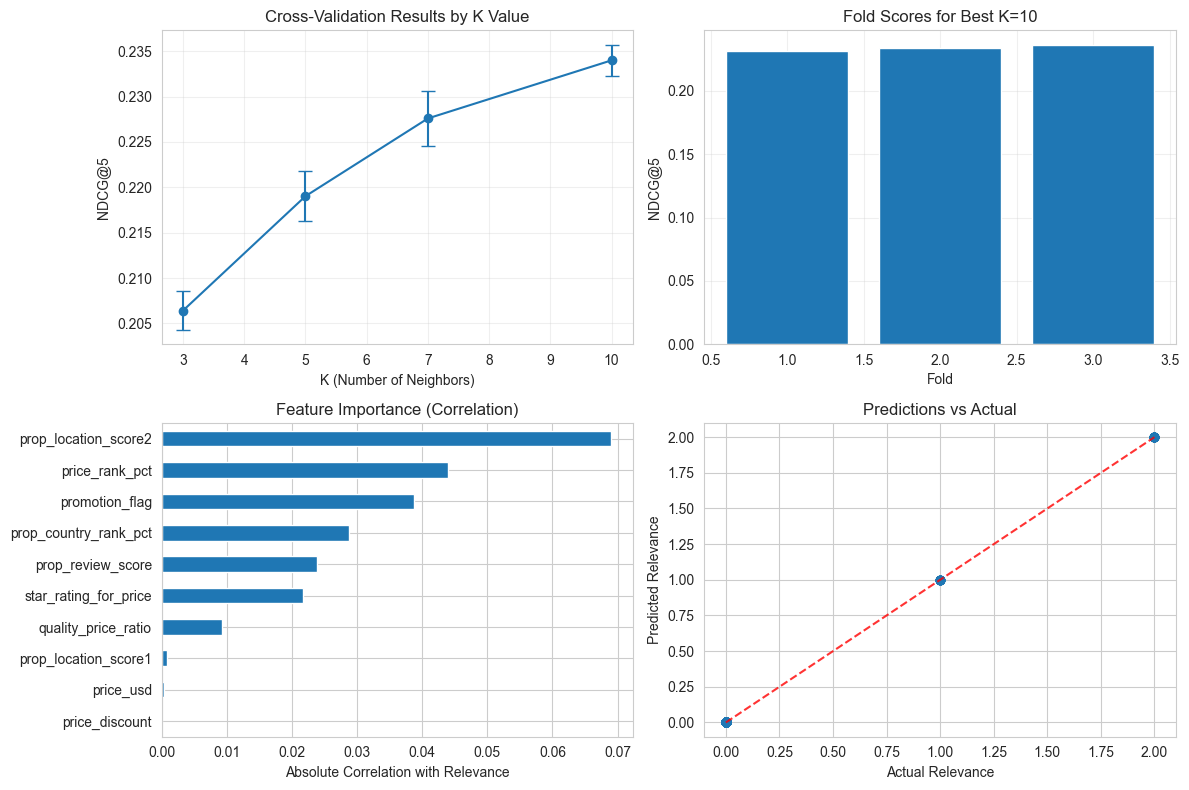

In [11]:
# Visualize cross-validation results
plt.figure(figsize=(12, 8))

# Plot 1: NDCG@5 by K value
plt.subplot(2, 2, 1)
k_values = list(cv_results.keys())
mean_scores = [cv_results[k]['mean_ndcg'] for k in k_values]
std_scores = [cv_results[k]['std_ndcg'] for k in k_values]

plt.errorbar(k_values, mean_scores, yerr=std_scores, marker='o', capsize=5)
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('NDCG@5')
plt.title('Cross-Validation Results by K Value')
plt.grid(True, alpha=0.3)

# Plot 2: Fold scores for best K
plt.subplot(2, 2, 2)
best_fold_scores = cv_results[best_k]['fold_scores']
plt.bar(range(1, len(best_fold_scores) + 1), best_fold_scores)
plt.xlabel('Fold')
plt.ylabel('NDCG@5')
plt.title(f'Fold Scores for Best K={best_k}')
plt.grid(True, alpha=0.3)

# Plot 3: Feature importance (correlation with target)
plt.subplot(2, 2, 3)
feature_correlations = X.corrwith(y).abs().sort_values(ascending=True)
feature_correlations.plot(kind='barh')
plt.xlabel('Absolute Correlation with Relevance')
plt.title('Feature Importance (Correlation)')

# Plot 4: Distribution of predictions vs actual
plt.subplot(2, 2, 4)
# Use best model to get predictions on a subset
sample_indices = np.random.choice(len(X_scaled), size=min(1000, len(X_scaled)), replace=False)
X_sample = X_scaled.iloc[sample_indices]
y_sample = y.iloc[sample_indices]

model_best = KNNRankingModel(n_neighbors=best_k, weights='distance')
model_best.fit(X_scaled, y)
y_pred_sample = model_best.predict(X_sample)

plt.scatter(y_sample, y_pred_sample, alpha=0.6)
plt.xlabel('Actual Relevance')
plt.ylabel('Predicted Relevance')
plt.title('Predictions vs Actual')
plt.plot([0, 2], [0, 2], 'r--', alpha=0.8)

plt.tight_layout()
plt.show()

## 7. Final Model Training and Feature Analysis

In [12]:
# Train final model with best parameters
print(f"Training final model with K={best_k}...")

final_model = KNNRankingModel(n_neighbors=best_k, weights='distance')
final_model.fit(X_scaled, y)

print("Final model training completed.")

# Analyze feature importance through correlation and prediction impact
print("\nFeature Analysis:")
print("=" * 40)


feature_correlations = X.corrwith(y).abs().sort_values(ascending=False)
print("\nFeature correlations with relevance (absolute):")
for feature, corr in feature_correlations.items():
    print(f"{feature:25s}: {corr:.4f}")


print("\nFeature statistics by relevance level:")
relevance_stats = df_sample.groupby('relevance')[model_features].mean()
print(relevance_stats.T)


print("\nFeature value ranges:")
for feature in model_features:
    min_val = X[feature].min()
    max_val = X[feature].max()
    mean_val = X[feature].mean()
    print(f"{feature:25s}: [{min_val:8.4f}, {max_val:8.4f}], mean: {mean_val:8.4f}")

Training final model with K=10...
Final model training completed.

Feature Analysis:

Feature correlations with relevance (absolute):
prop_location_score2     : 0.0689
price_rank_pct           : 0.0439
promotion_flag           : 0.0387
prop_country_rank_pct    : 0.0288
prop_review_score        : 0.0238
star_rating_for_price    : 0.0217
quality_price_ratio      : 0.0092
prop_location_score1     : 0.0008
price_usd                : 0.0004
price_discount           : 0.0001

Feature statistics by relevance level:
relevance                    0         1        2
prop_location_score2    0.1245    0.1626   0.1799
price_discount        -65.2590 -203.7252 -19.0176
price_rank_pct          0.5229    0.4772   0.4534
prop_location_score1    2.8852    2.9837   2.8642
prop_country_rank_pct   0.4982    0.5355   0.5384
star_rating_for_price   0.7726    0.8618   0.8101
quality_price_ratio     5.1459    6.1025   8.6736
promotion_flag          0.2135    0.2734   0.3003
prop_review_score       3.7716    3.

## 8. Test Data Preparation and Prediction

In [13]:
# Load test data
print("Loading test data...")
try:
    df_test = pd.read_csv("../data/test_set_VU_DM_feature_engin.csv")
    print(f"Loaded feature engineered test dataset with shape: {df_test.shape}")
except FileNotFoundError:
    print("Feature engineered test file not found. Loading original and applying feature engineering...")
    df_test = pd.read_csv("../data/test_set_VU_DM.csv")
    print(f"Loaded original test dataset with shape: {df_test.shape}")
    

    for col in df_test.select_dtypes(include=[np.number]).columns:
        if df_test[col].isnull().any():
            df_test[col] = df_test[col].fillna(df_test[col].median())
    
    # Create the same engineered features
    df_test['price_per_night'] = df_test['price_usd'] / df_test['srch_length_of_stay']
    df_test.loc[df_test['srch_length_of_stay'] == 0, 'price_per_night'] = df_test['price_usd']
    
    df_test['value_for_money_normalized'] = df_test['prop_starrating'] / df_test['price_per_night']
    df_test['value_for_money_normalized'] = df_test['value_for_money_normalized'] / df_test['value_for_money_normalized'].max()
    
    df_test['price_normalized'] = df_test.groupby('srch_id')['price_usd'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-10))
    
    df_test['price_rank_pct'] = df_test.groupby('srch_id')['price_usd'].rank(pct=True)
    
    df_test['prop_country_rank_pct'] = df_test.groupby('prop_country_id')['prop_starrating'].rank(pct=True)
    
    df_test['star_rating_for_price'] = df_test['prop_starrating'] / np.log1p(df_test['price_per_night'])
    
    df_test['quality_price_ratio'] = (0.5 * (df_test['prop_starrating'] / 5) + 
                                      0.5 * (df_test['prop_review_score'] / 5)) / (df_test['price_normalized'] + 1e-10)
    df_test['quality_price_ratio'] = df_test['quality_price_ratio'].fillna(df_test['quality_price_ratio'].median())
    df_test['quality_price_ratio'] = df_test['quality_price_ratio'].replace([np.inf, -np.inf], 
                                                                             df_test['quality_price_ratio'].median())
    
    df_test['price_discount'] = 1 - (df_test['price_usd'] / np.exp(df_test['prop_log_historical_price']))

print(f"Test data shape: {df_test.shape}")
print(f"Number of unique test searches: {df_test['srch_id'].nunique():,}")

Loading test data...
Loaded feature engineered test dataset with shape: (3000000, 146)
Test data shape: (3000000, 146)
Number of unique test searches: 120,819


In [14]:
# Prepare test features
print("Preparing test features...")

missing_test_features = [f for f in model_features if f not in df_test.columns]
if missing_test_features:
    print(f"Missing features in test data: {missing_test_features}")
    # Handle missing features (could create them or skip)
    available_test_features = [f for f in model_features if f in df_test.columns]
    print(f"Using available features: {available_test_features}")
else:
    available_test_features = model_features
    print("All features available in test data.")

# Extract test features
X_test = df_test[available_test_features].copy()

# Handle missing values in test features
for col in available_test_features:
    if X_test[col].isnull().any():
        # Use the median from training data
        train_median = X[col].median()
        X_test[col] = X_test[col].fillna(train_median)
        print(f"Filled {col} missing values with training median: {train_median}")

# Scale test features using the same scaler fitted on training data
print("Scaling test features...")
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=available_test_features, index=X_test.index)

print(f"Test feature matrix shape: {X_test_scaled.shape}")

Preparing test features...
All features available in test data.
Scaling test features...
Test feature matrix shape: (3000000, 10)


## 9. Generate Predictions and Rankings

In [15]:
# Generate predictions for test data
print("Generating predictions for test data...")

# Get search IDs for test data
test_search_ids = df_test['srch_id']

# Get rankings using the final model
test_results = final_model.rank_within_searches(X_test_scaled, test_search_ids)

# Add property IDs for submission
test_results['prop_id'] = df_test['prop_id'].values

print(f"Generated predictions for {len(test_results):,} hotels in {test_search_ids.nunique():,} searches")

# Display sample of results
print("\nSample of test predictions:")
sample_search = test_search_ids.iloc[0]
sample_results = test_results[test_results['search_id'] == sample_search].sort_values('rank')
print(sample_results.head(10))

Generating predictions for test data...
Generated predictions for 3,000,000 hotels in 120,819 searches

Sample of test predictions:
    search_id  predicted_relevance    rank  prop_id
1           1               0.4978  1.0000     5543
4           1               0.4441  2.0000    24194
23          1               0.3613  3.0000    99484
9           1               0.2653  4.0000    54937
13          1               0.1667  5.0000    63894
6           1               0.1572  6.0000    34263
20          1               0.1157  7.0000    90385
12          1               0.0981  8.0000    61934
18          1               0.0788  9.0000    82231
7           1               0.0000 10.0000    37567


## 10. Create Submission File

In [16]:
# Create submission file in the required format
print("Creating submission file...")

# Sort by search_id and rank to get the correct order
submission_data = test_results.sort_values(['search_id', 'rank'])

# Create submission dataframe
submission = pd.DataFrame({
    'srch_id': submission_data['search_id'],
    'prop_id': submission_data['prop_id']
})

# Save submission file
submission_filename = '../data/submission_knn_baseline.csv'
submission.to_csv(submission_filename, index=False)

print(f"Submission file saved as '{submission_filename}'")
print(f"Submission shape: {submission.shape}")

# Display first few rows of submission
print("\nFirst 10 rows of submission:")
print(submission.head(10))

# Verify submission format
print("\nSubmission verification:")
print(f"Number of unique searches: {submission['srch_id'].nunique():,}")
print(f"Total hotel recommendations: {len(submission):,}")
print(f"Average hotels per search: {len(submission) / submission['srch_id'].nunique():.1f}")

Creating submission file...
Submission file saved as 'submission_knn_baseline.csv'
Submission shape: (3000000, 2)

First 10 rows of submission:
    srch_id  prop_id
1         1     5543
4         1    24194
23        1    99484
9         1    54937
13        1    63894
6         1    34263
20        1    90385
12        1    61934
18        1    82231
0         1     3180

Submission verification:
Number of unique searches: 120,819
Total hotel recommendations: 3,000,000
Average hotels per search: 24.8


## 11. Model Summary and Analysis

In [17]:
# Summary of model performance and characteristics
print("=" * 60)
print("KNN BASELINE MODEL SUMMARY")
print("=" * 60)

print(f"\nModel Configuration:")
print(f"  Algorithm: K-Nearest Neighbors (KNN)")
print(f"  Number of neighbors (K): {best_k}")
print(f"  Distance metric: {final_model.metric}")
print(f"  Weighting scheme: {final_model.weights}")
print(f"  Feature scaling: StandardScaler")

print(f"\nTraining Data:")
print(f"  Original dataset size: {len(df_train):,} rows")
print(f"  Sample size used: {len(df_sample):,} rows ({SAMPLE_FRACTION*100}%)")
print(f"  Number of searches: {df_sample['srch_id'].nunique():,}")
print(f"  Number of features: {len(model_features)}")

print(f"\nFeatures Used:")
for i, feature in enumerate(model_features, 1):
    correlation = feature_correlations.get(feature, 0)
    print(f"  {i:2d}. {feature:25s} (corr: {correlation:6.4f})")

print(f"\nCross-Validation Results:")
best_results = cv_results[best_k]
print(f"  NDCG@5: {best_results['mean_ndcg']:.4f} ± {best_results['std_ndcg']:.4f}")
print(f"  Number of folds: {N_FOLDS}")

print(f"\nTest Predictions:")
print(f"  Test dataset size: {len(df_test):,} rows")
print(f"  Number of test searches: {df_test['srch_id'].nunique():,}")
print(f"  Submission file: {submission_filename}")

print(f"\nModel Characteristics:")
print(f"  - Uses hotel similarity based on property features")
print(f"  - Distance-weighted voting from nearest neighbors")
print(f"  - Handles ranking within each search query")
print(f"  - Baseline approach for comparison with advanced models")

print("\n" + "=" * 60)

KNN BASELINE MODEL SUMMARY

Model Configuration:
  Algorithm: K-Nearest Neighbors (KNN)
  Number of neighbors (K): 10
  Distance metric: euclidean
  Weighting scheme: distance
  Feature scaling: StandardScaler

Training Data:
  Original dataset size: 4,958,347 rows
  Sample size used: 495,448 rows (10.0%)
  Number of searches: 19,979
  Number of features: 10

Features Used:
   1. prop_location_score2      (corr: 0.0689)
   2. price_discount            (corr: 0.0001)
   3. price_rank_pct            (corr: 0.0439)
   4. prop_location_score1      (corr: 0.0008)
   5. prop_country_rank_pct     (corr: 0.0288)
   6. star_rating_for_price     (corr: 0.0217)
   7. quality_price_ratio       (corr: 0.0092)
   8. promotion_flag            (corr: 0.0387)
   9. prop_review_score         (corr: 0.0238)
  10. price_usd                 (corr: 0.0004)

Cross-Validation Results:
  NDCG@5: 0.2340 ± 0.0017
  Number of folds: 3

Test Predictions:
  Test dataset size: 3,000,000 rows
  Number of test searche